### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-02-26 11:41:11.028650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 11:41:11.065034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 11:41:11.065067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 11:41:11.066674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 11:41:11.076097: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["angle"], inplace=True)

display(csv_df)

,speed
image_id,
1,0.0
2,1.0
3,1.0
4,1.0
5,0.0
...,...
13794,1.0
13795,1.0
13796,0.0


Check the data

(array([ 3390.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10403.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

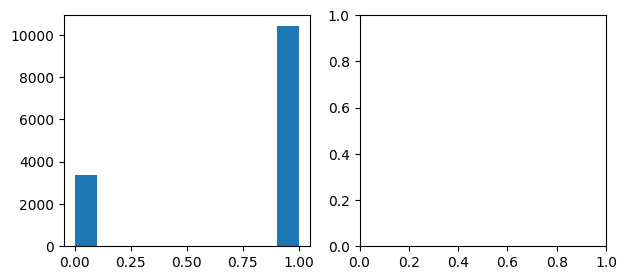

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].hist(csv_df["speed"])

In [4]:
# for rs in range(10000):
#     X = np.array(csv_df.index)
#     y = np.array(csv_df['angle'])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rs)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.15/0.85), random_state=rs)

#     # print(X_train.shape)
#     # print(X_val.shape)
#     # print(X_test.shape)
#     # print(X.shape)

#     train_count = pd.Series(y_train).value_counts()
#     train_count = train_count / sum(train_count) * 100
#     # val_count = pd.Series(y_val).value_counts()
#     # val_count = val_count / sum(val_count) * 100
#     # test_count = pd.Series(y_test).value_counts()
#     # test_count = test_count / sum(test_count) * 100

#     ori_count = pd.Series(y).value_counts()
#     ori_count = ori_count / sum(ori_count) * 100

#     diff = (sum(abs(train_count-ori_count)))

#     if (diff < 0.6):
#         print(f"random state: {rs}")
#         print(diff)

#     bar_width = 0.015
#     # plt.bar(val_count.index-bar_width, train_count, width=bar_width)
#     # plt.bar(train_count.index, train_count, width=bar_width)
#     # plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
#     # plt.bar(test_count.index+bar_width, train_count, width=bar_width)

575 0.07074420328796549


<BarContainer object of 2 artists>

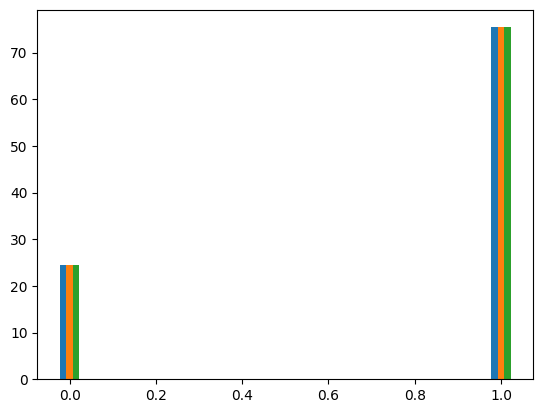

In [5]:
rs = 575

X = np.array(csv_df.index)
y = np.array(csv_df["speed"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=rs
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
)

train_count = pd.Series(y_train).value_counts()
train_count = train_count / sum(train_count) * 100
val_count = pd.Series(y_val).value_counts()
val_count = val_count / sum(val_count) * 100
test_count = pd.Series(y_test).value_counts()
test_count = test_count / sum(test_count) * 100

# print(train_count)
# print(val_count)
# print(test_count)

ori_count = pd.Series(y).value_counts()
ori_count = ori_count / sum(ori_count) * 100

# print(ori_count)

diff = sum(abs(train_count - ori_count))

diff = (abs(train_count[0] - test_count[0]) + abs(train_count[0]-val_count[0]))

if (diff < 0.1):
    print(rs, diff)



# if diff < 0.7:
#     print(f"random state: {rs}")
#     print(diff)

bar_width = 0.015
plt.bar(val_count.index - bar_width, train_count, width=bar_width)
plt.bar(train_count.index, train_count, width=bar_width)
# plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
plt.bar(test_count.index + bar_width, train_count, width=bar_width)

In [6]:
# sample_probs_tensor = tf.constant(p_for_random_choice, dtype=tf.float32)

# X_train_tensor = tf.constant(X_train, dtype=tf.int32)
# y_train_tensor = tf.constant(y_train, dtype=tf.float32)

# NUM_SAMPLES = 32*400

# def sample_indices():
#     return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

# sampled_indices = sample_indices()

# X_train_os = tf.gather(X_train_tensor, sampled_indices)
# y_train_os = tf.gather(y_train_tensor, sampled_indices)

# train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

In [7]:
# ids = []
# angles = []
# for id, angle in train_ds:
#     ids.append(id.numpy())
#     angles.append(angle.numpy())

In [8]:
# y_count = pd.Series(angles).value_counts().sort_index()
# plt.bar(y_count.index, y_count, width=0.04)
# plt.title("Distribution of angles after oversampling")

In [9]:
X_train_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_train
]
X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

In [10]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, speed):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, speed

def image_id_to_path(image_id, speed):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, speed

In [11]:

train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

2025-02-26 11:41:13.981327: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 11:41:14.034831: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 11:41:14.034876: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 11:41:14.042110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 11:41:14.042161: I external/local_xla/xla/stream_executor

9655
2069


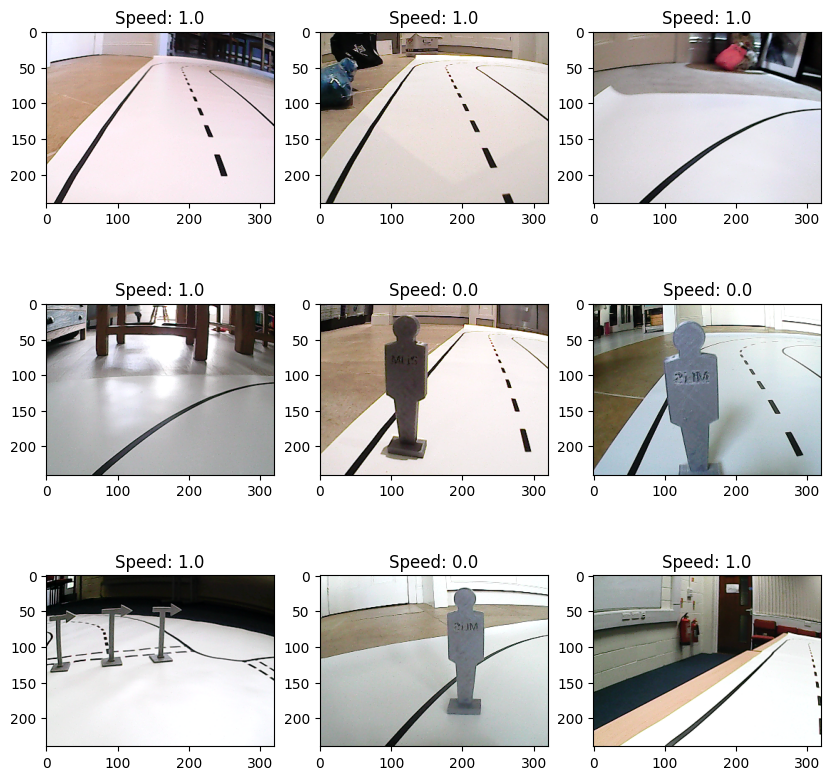

In [12]:
plt.figure(figsize=(10, 10))
i = 0

for image, speed in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    speed = speed.numpy()
    plt.title(f"Speed: {speed}")
    i += 1

In [13]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [14]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, speed, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, speed

Test augment function

20


2025-02-26 11:41:15.433439: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Augmented image shape: (240, 320, 3)


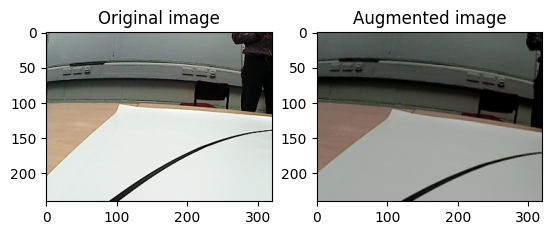

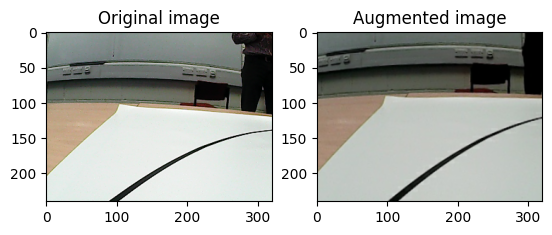

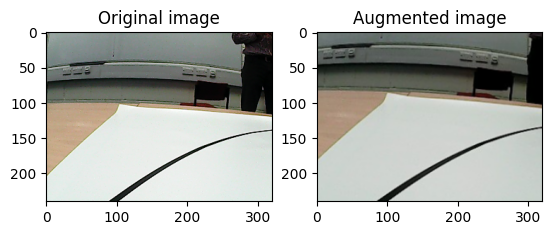

In [15]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, speed in train_ds.skip(skip).take(1):
        augmented_image, speed = augment(image, speed, None)
        visualise(image, augmented_image)

for image, speed in train_ds.take(1):
    aug_image, aug_speed = augment(image, speed)
    print(f"Augmented image shape: {aug_image.shape}")

In [16]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
def scale_ds(image, speed):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, speed


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
def rephrase_ds(image, speed):
    return image, {"speed_output": speed}


train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
batch_size = 64


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [20]:
print(y_train)
class_weight = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weight[0], 1: class_weight[1]}
print(class_weight_dict)

[1. 1. 1. ... 0. 0. 1.]
{0: 2.0334877843302444, 1: 0.6630270567229776}


In [21]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

print(base_model.output.shape)

(None, 8, 10, 960)


In [22]:
feature_extractor = base_model.output

print(feature_extractor.shape)

# # Conv + dense head

x = layers.GlobalAveragePooling2D()(feature_extractor)
x = layers.Dense(512, activation='relu', name='speed_dense_2')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu', name='speed_dense_1')(x)
x = layers.Dense(1, activation='sigmoid', name='speed_dense_0')(x)

speed_output = x

model = Model(inputs=base_model.input, outputs={'speed_output': speed_output}, name="my_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    # loss={"speed_output": "mse"},
    loss={"speed_output": WeightedBinaryCrossEntropy(class_weight_dict)},
    metrics={"speed_output": ["mse", "accuracy"]},
)

# model.summary()

(None, 8, 10, 960)


In [23]:
sub_model = Model(feature_extractor, speed_output)
tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

Saved model image: model.png


In [24]:
def lr_schedule(epoch, lr):
    initial_lr = learning_rate
    if epoch == 0:
        return 0.002
        return initial_lr * 2
    decay = 0.3
    return initial_lr / (1 + ((epoch-1) // 3) * decay)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

Epoch  1: 0.002000
Epoch  2: 0.001000
Epoch  3: 0.001000
Epoch  4: 0.001000
Epoch  5: 0.000769
Epoch  6: 0.000769
Epoch  7: 0.000769
Epoch  8: 0.000625
Epoch  9: 0.000625
Epoch 10: 0.000625
Epoch 11: 0.000526
Epoch 12: 0.000526
Epoch 13: 0.000526
Epoch 14: 0.000455
Epoch 15: 0.000455
Epoch 16: 0.000455
Epoch 17: 0.000400
Epoch 18: 0.000400
Epoch 19: 0.000400
Epoch 20: 0.000357
Epoch 21: 0.000357
Epoch 22: 0.000357
Epoch 23: 0.000323
Epoch 24: 0.000323
Epoch 25: 0.000323
Epoch 26: 0.000294
Epoch 27: 0.000294
Epoch 28: 0.000294
Epoch 29: 0.000270
Epoch 30: 0.000270


### Train model

In [25]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

history_callback = keras.callbacks.History()

NUM_OF_EPOCHS = 50

try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=NUM_OF_EPOCHS,
        steps_per_epoch= train_ds_length // batch_size,
        validation_steps= val_ds_length // batch_size,
        callbacks=[checkpoint, history_callback, lr_scheduler],
        verbose=1,
    )
except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/50


2025-02-26 11:41:25.072299: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-26 11:41:25.249055: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-26 11:41:27.381982: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5ec3eacdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-26 11:41:27.382035: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-02-26 11:41:27.388918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740570087.460958   19238 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - ETA: 0s - loss: 0.1704 - mse: 0.0489 - accuracy: 0.9337
Epoch 1: saving model to checkpoints/model_epoch_01.keras
150/150 [==============================] - 33s 152ms/step - loss: 0.1704 - mse: 0.0489 - accuracy: 0.9337 - val_loss: 0.0876 - val_mse: 0.0261 - val_accuracy: 0.9658 - lr: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.0978 - mse: 0.0278 - accuracy: 0.9634
Epoch 2: saving model to checkpoints/model_epoch_02.keras
150/150 [==============================] - 23s 153ms/step - loss: 0.0978 - mse: 0.0278 - accuracy: 0.9634 - val_loss: 0.0675 - val_mse: 0.0205 - val_accuracy: 0.9702 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.0867 - mse: 0.0245 - accuracy: 0.9672
Epoch 3: saving model to checkpoints/model_epoch_03.keras
150/150 [============

2025-02-26 11:59:09.402936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15465758611169079583


### Save model and plot

In [26]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'speed_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

['loss', 'mse', 'accuracy', 'val_loss', 'val_mse', 'val_accuracy']


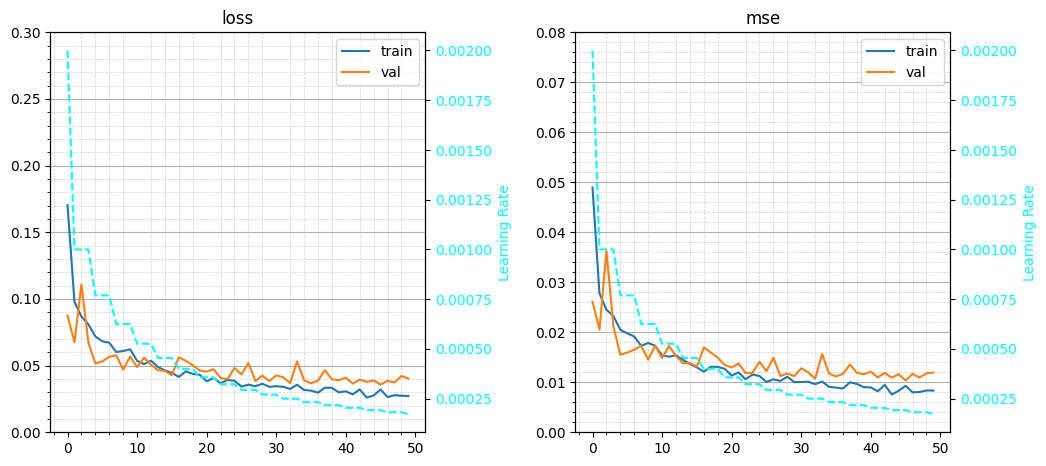

In [27]:
history = history_callback.history
history_1 = history_callback.history

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


ax = ax.ravel()

keys = list(history.keys())
print(keys)
needed = [0, 1]
groups = [keys[i] for i in needed]

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            label = "val" if key.startswith("val") else "train"
            ax[j].plot(history[key], label=label)
            ax[j].set_title(groups[j])
            ax[j].minorticks_on()
            ax[j].grid(True, axis="y")
            ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[j].legend()
            break

ylim_list = [
    (0, 0.3),
    (0, 0.08),
]
for i in range(len(groups)):
    # l, u = ylim_list[i]
    ax[i].set_ylim(ylim_list[i])

learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")

# ax[1].text(20 ,0,f"OverSampling max {upper}, v2S", rotation=90, ha='center')

# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



plt.savefig(f"{folder_path}/{name_template}.png")

In [28]:
for layer in base_model.layers[-5:]:  # Freeze all but the last 20 layers
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"speed_output": WeightedBinaryCrossEntropy(class_weight_dict)},
    metrics={"speed_output": ["mse", "accuracy"]},
)

def lr_schedule_cont(epoch, lr):
    return lr_schedule(epoch+NUM_OF_EPOCHS, lr)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule_cont(epoch, 0):.6f}")

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule_cont, verbose=1)

Epoch  1: 0.000172
Epoch  2: 0.000172
Epoch  3: 0.000164
Epoch  4: 0.000164
Epoch  5: 0.000164
Epoch  6: 0.000156
Epoch  7: 0.000156
Epoch  8: 0.000156
Epoch  9: 0.000149
Epoch 10: 0.000149
Epoch 11: 0.000149
Epoch 12: 0.000143
Epoch 13: 0.000143
Epoch 14: 0.000143
Epoch 15: 0.000137
Epoch 16: 0.000137
Epoch 17: 0.000137
Epoch 18: 0.000132
Epoch 19: 0.000132
Epoch 20: 0.000132
Epoch 21: 0.000127
Epoch 22: 0.000127
Epoch 23: 0.000127
Epoch 24: 0.000122
Epoch 25: 0.000122
Epoch 26: 0.000122
Epoch 27: 0.000118
Epoch 28: 0.000118
Epoch 29: 0.000118
Epoch 30: 0.000114


In [29]:
# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=20,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)

In [30]:
# name_template = f'{name_template}_cont'

# folder_path = f"Models/{name_template}"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# filename = f"{folder_path}/{name_template}.keras"
# model.save(filename)
# filename = f"{folder_path}/{name_template}.weights.h5"
# model.save_weights(filename)

# history = history_callback.history

# filename = f"{folder_path}/{name_template}_history.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(history, f)

In [31]:
# history_2 = history_callback.history

# history = {}

# # Merge using numpy.concatenate
# for key in history_1.keys():
#     history[key] = np.concatenate([history_1[key], history_2[key]])

# history = history_callback.history

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


# ax = ax.ravel()

# keys = list(history.keys())
# print(keys)
# needed = [0, 1]
# groups = [keys[i] for i in needed]

# for key in history.keys():
#     for j in range(len(groups)):
#         if key.endswith(groups[j]):
#             label = "val" if key.startswith("val") else "train"
#             ax[j].plot(history[key], label=label)
#             ax[j].set_title(groups[j])
#             ax[j].minorticks_on()
#             ax[j].grid(True, axis="y")
#             ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
#             ax[j].legend()
#             break

# ylim_list = [
#     (0.001, 0.015),
#     (0.04, 0.08),
# ]
# for i in range(len(groups)):
#     # l, u = ylim_list[i]
#     ax[i].set_ylim(ylim_list[i])

# learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

# for i in range(len(groups)):
#     ax_lr = ax[i].twinx()
#     ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
#     ax_lr.set_ylabel("Learning Rate", color="cyan")
#     ax_lr.tick_params(axis="y", labelcolor="cyan")

# # ax[1].text(13 ,0,f"OverSampling max {upper}, v2M", rotation=90, ha='center')

# # model_details_text = [
# #     f"Model details: Batch {batch_size}, LR: {learning_rate}",
# #     "EfficientNetV2S",
# #     "two paths: ",
# #     "GlobalAveragePooling2D+norm+dropout and ",
# #     "conv2D(128,(3,3)) -> norm -> flatten",
# #     "merge -> norm -> dense(2560) -> dropout",
# #     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# # ]

# # ax[-1].axis("off")
# # ax[-2].axis("off")
# # ax[-3].axis("off")
# # for i in range(len(model_details_text)):
# #     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



# plt.savefig(f"{folder_path}/{name_template}.png")

In [32]:
print(len(history_1['loss']))

50
